In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import joblib
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta

In [3]:
nyc_weather = pd.read_csv('/content/drive/MyDrive/Central_Park_Weather.csv')

print(nyc_weather.head())

                     name    datetime  tempmax  tempmin  temp  feelslikemax  \
0  Central Park, New York  2018-10-30     12.9      6.2   9.1          12.9   
1  Central Park, New York  2018-10-31     17.2      7.2  12.5          17.2   
2  Central Park, New York  2018-11-01     20.7     14.3  17.1          20.7   
3  Central Park, New York  2018-11-02     21.6     17.9  19.7          21.6   
4  Central Park, New York  2018-11-03     18.4     10.0  13.5          18.4   

   feelslikemin  feelslike   dew  humidity  ...  solarenergy  uvindex  \
0           2.9        7.3  -0.4      53.5  ...         12.7        6   
1           6.3       12.3   4.7      59.6  ...         11.6        6   
2          14.3       17.1  12.0      72.4  ...         10.3        5   
3          17.9       19.7  16.8      83.3  ...          2.9        1   
4          10.0       13.5   8.0      72.6  ...          7.5        5   

   severerisk              sunrise               sunset  moonphase  \
0         NaN  2

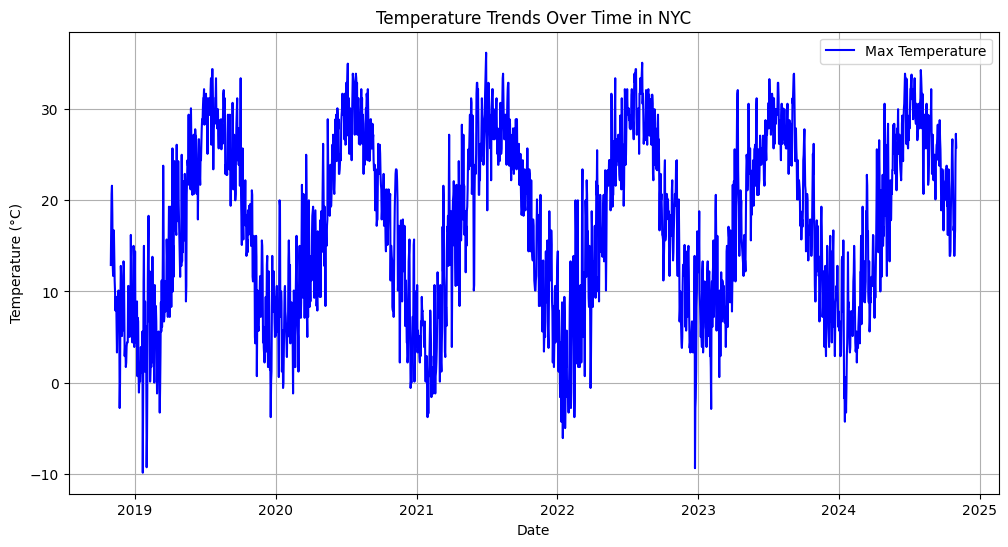

In [4]:
# Line plot for temperature trends over time
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(nyc_weather['datetime']), nyc_weather['tempmax'], label='Max Temperature', color='b')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Trends Over Time in NYC')
plt.legend()
plt.grid(True)
plt.show()

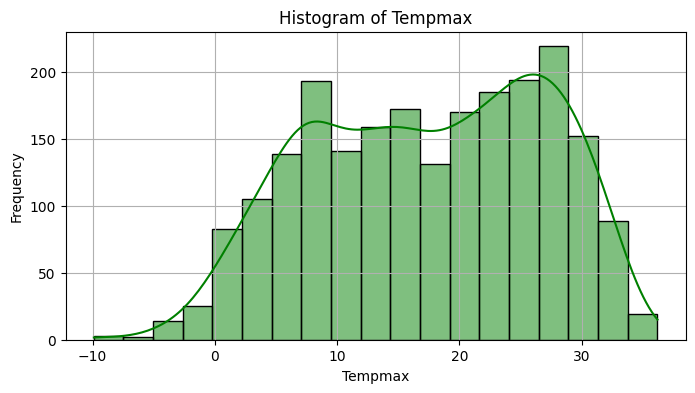

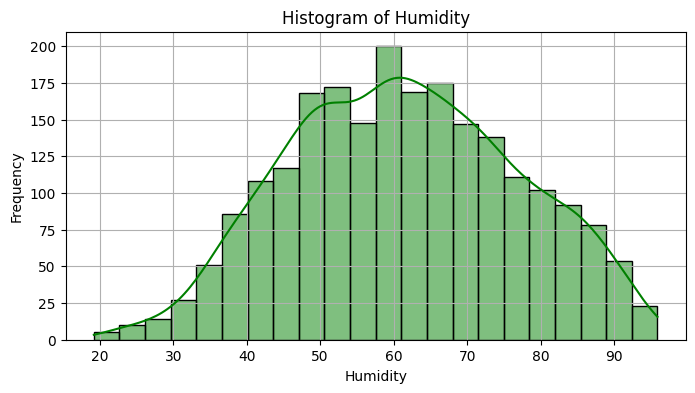

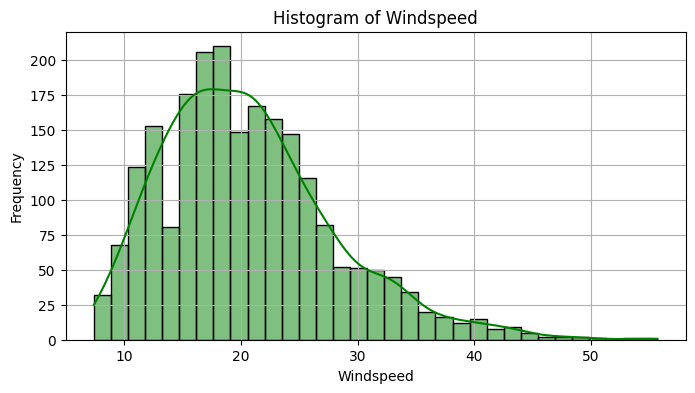

In [5]:
# Histogram of key features (e.g., temperature, humidity, wind speed)
features = ['tempmax', 'humidity', 'windspeed']
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(nyc_weather[feature], kde=True, color='g')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature.capitalize()}')
    plt.grid(True)
    plt.show()

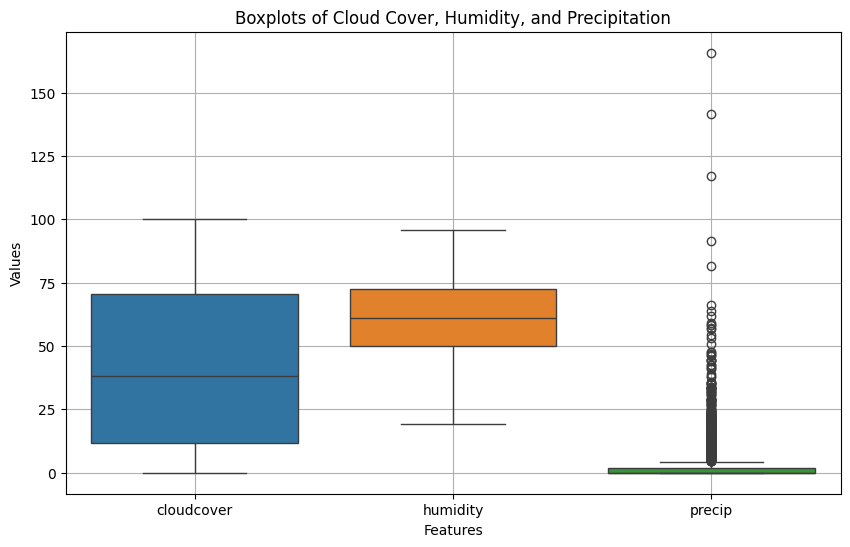

In [6]:
# Boxplots for cloud cover, humidity, and precipitation
plt.figure(figsize=(10, 6))
sns.boxplot(data=nyc_weather[['cloudcover', 'humidity', 'precip']])
plt.title('Boxplots of Cloud Cover, Humidity, and Precipitation')
plt.xlabel('Features')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [7]:
# Feature Preprocessing
# Convert datetime to datetime format
nyc_weather['datetime'] = pd.to_datetime(nyc_weather['datetime'])

# Drop unnecessary columns
columns_to_drop = ['name', 'stations', 'moonphase', 'description', 'icon', 'severerisk', 'sunrise', 'sunset', 'conditions', 'preciptype']
nyc_weather = nyc_weather.drop(columns=columns_to_drop)

# Handle missing values
nyc_weather = nyc_weather.fillna(method='ffill')

# Feature Engineering
# Lagged Features: previous day temperatures
nyc_weather['tempmax_1d'] = nyc_weather['tempmax'].shift(1)
nyc_weather['tempmin_1d'] = nyc_weather['tempmin'].shift(1)
nyc_weather['temp_1d'] = nyc_weather['temp'].shift(1)

# Daily temperature range
nyc_weather['temp_range'] = nyc_weather['tempmax'] - nyc_weather['tempmin']

# Temperature Change from previous day
nyc_weather['tempmax_change'] = nyc_weather['tempmax'] - nyc_weather['tempmax'].shift(1)
nyc_weather['tempmin_change'] = nyc_weather['tempmin'] - nyc_weather['tempmin'].shift(1)

# Rolling averages
nyc_weather['tempmax_3d_avg'] = nyc_weather['tempmax'].rolling(window=3).mean()
nyc_weather['tempmax_7d_avg'] = nyc_weather['tempmax'].rolling(window=7).mean()

nyc_weather['humidity_3d_avg'] = nyc_weather['humidity'].rolling(window=3).mean()
nyc_weather['windspeed_3d_avg'] = nyc_weather['windspeed'].rolling(window=3).mean()

# Date-based features
nyc_weather['day_of_year'] = nyc_weather['datetime'].dt.dayofyear
nyc_weather['sin_day'] = np.sin(2 * np.pi * nyc_weather['day_of_year'] / 365.25)
nyc_weather['cos_day'] = np.cos(2 * np.pi * nyc_weather['day_of_year'] / 365.25)

# Drop rows with NaN values introduced by lagging or rolling
nyc_weather = nyc_weather.dropna().reset_index(drop=True)

print(nyc_weather.head())

    datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
0 2018-11-05     11.7      9.3  10.3          11.7           7.3       10.1   
1 2018-11-06     14.4      9.4  12.3          14.4           7.5       12.3   
2 2018-11-07     16.7     11.1  14.0          16.7          11.1       14.0   
3 2018-11-08     13.9      7.2  10.1          13.9           4.8        9.0   
4 2018-11-09     11.2      5.0   8.7          11.2           2.3        7.2   

    dew  humidity  precip  ...  temp_range  tempmax_change  tempmin_change  \
0   7.7      84.1   7.195  ...         2.4            -1.2             3.1   
1  11.7      95.8  18.007  ...         5.0             2.7             0.1   
2   5.3      58.0   0.000  ...         5.6             2.3             1.7   
3  -0.4      48.5   0.000  ...         6.7            -2.8            -3.9   
4   3.3      70.8  18.784  ...         6.2            -2.7            -2.2   

   tempmax_3d_avg  tempmax_7d_avg  humidity_3d_avg  wind

<ipython-input-7-9ca91cb2857a>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nyc_weather = nyc_weather.fillna(method='ffill')


In [8]:
# Define target and features for the model
X = nyc_weather.drop(columns=['datetime', 'tempmax'])  # Features excluding datetime and target column
y = nyc_weather['tempmax']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Train your linear regression model
LRmodel = LinearRegression()
LRmodel.fit(X_train, y_train)

# Make predictions using the test set
y_pred_lr = LRmodel.predict(X_test)

# Evaluate the model performance
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - Mean Squared Error: {mse_lr}")
print(f"Linear Regression - R-squared: {r2_lr}")

# Save the model to a file named 'linear_regression_model.pkl'
joblib.dump(LRmodel, 'linear_regression_model.pkl')
print("Linear regression model saved successfully.")

Linear Regression - Mean Squared Error: 6.841476583654742e-27
Linear Regression - R-squared: 1.0
Linear regression model saved successfully.


In [10]:
# Train the RandomForest model
RFmodel = RandomForestRegressor(n_estimators=100, random_state=42)
RFmodel.fit(X_train, y_train)

# Make predictions using the test set
y_pred_rf = RFmodel.predict(X_test)

# Evaluate the model performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R-squared: {r2_rf}")

# Save the RandomForest model to a file named 'random_forest_model.pkl'
joblib.dump(RFmodel, 'random_forest_model.pkl')
print("RandomForest model saved successfully.")

Random Forest - Mean Squared Error: 0.25645066894977153
Random Forest - R-squared: 0.997311882930939
RandomForest model saved successfully.


In [11]:
# Train the Gradient Boosting Regressor model
GBmodel = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
GBmodel.fit(X_train, y_train)

# Make predictions using the test set
y_pred_gb = GBmodel.predict(X_test)

# Evaluate the model performance
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - Mean Squared Error: {mse_gb}")
print(f"Gradient Boosting - R-squared: {r2_gb}")

# Save the RandomForest model to a file named 'random_forest_model.pkl'
joblib.dump(GBmodel, 'gradient_boosting_model.pkl')
print("GradientBoosting model saved successfully.")

Gradient Boosting - Mean Squared Error: 0.1856274044111826
Gradient Boosting - R-squared: 0.9980542527093936
GradientBoosting model saved successfully.


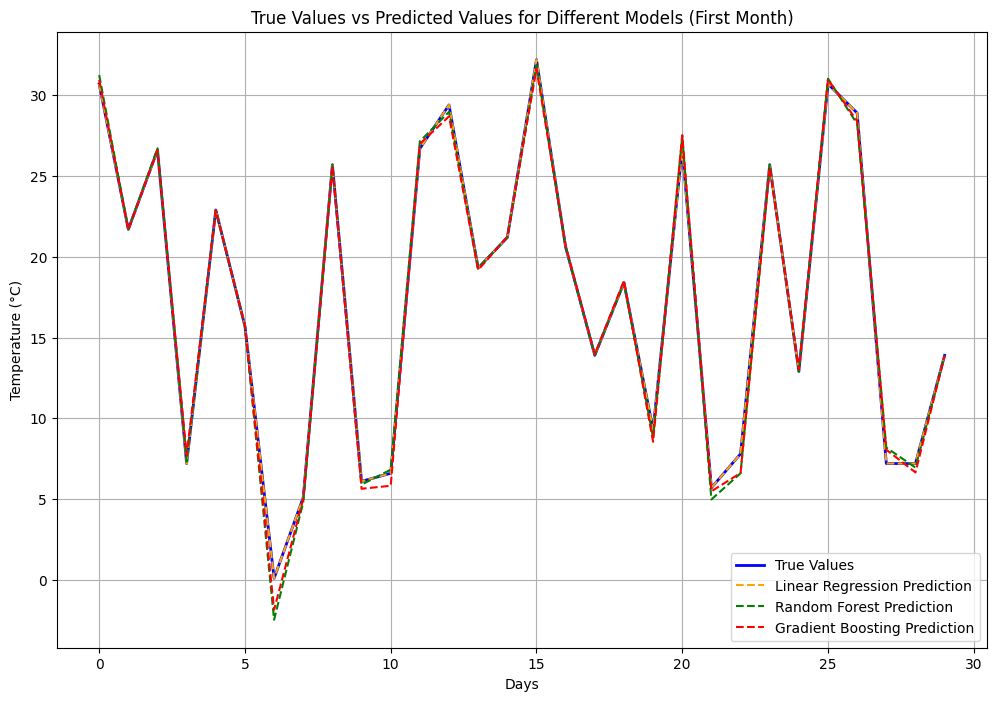

In [12]:
# Plotting the true values vs predicted values for the first month
plt.figure(figsize=(12, 8))

# Select the first 30 values for plotting
n_days = 30

# Plot the true values
plt.plot(y_test.reset_index(drop=True)[:n_days], label='True Values', color='blue', linewidth=2)

# Plot predictions from Linear Regression
plt.plot(y_pred_lr[:n_days], label='Linear Regression Prediction', color='orange', linestyle='--')

# Plot predictions from Random Forest
plt.plot(y_pred_rf[:n_days], label='Random Forest Prediction', color='green', linestyle='--')

# Plot predictions from Gradient Boosting
plt.plot(y_pred_gb[:n_days], label='Gradient Boosting Prediction', color='red', linestyle='--')

# Adding labels and legend
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.title('True Values vs Predicted Values for Different Models (First Month)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# API URL
api_url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Central%20Park%2C%20New%20York?unitGroup=metric&include=days%2Ccurrent%2Cevents&key=YCCHXGGLTBFHMGQFT8CESHZWS&contentType=json"

# Make the API call to fetch weather data
response = requests.get(api_url)

# Parse the JSON response
if response.status_code == 200:
    weather_data = response.json()
else:
    raise Exception(f"API request failed with status code {response.status_code}")

In [14]:
# Extract the current weather data
current_day = weather_data['days'][0]
current_conditions = weather_data['currentConditions']

# Extract features from the current day and conditions for prediction
features = {
    'tempmin': current_day['tempmin'],
    'temp': current_conditions['temp'],
    'feelslikemax': current_day['feelslikemax'],
    'feelslikemin': current_day['feelslikemin'],
    'feelslike': current_conditions['feelslike'],
    'dew': current_conditions['dew'],
    'humidity': current_conditions['humidity'],
    'precip': current_conditions['precip'],
    'precipprob': current_day['precipprob'],
    'precipcover': current_day['precipcover'],
    'snow': current_day['snow'],
    'snowdepth': current_day['snowdepth'],
    'windgust': current_conditions['windgust'],
    'windspeed': current_conditions['windspeed'],
    'winddir': current_conditions['winddir'],
    'sealevelpressure': current_conditions['pressure'],
    'cloudcover': current_conditions['cloudcover'],
    'visibility': current_conditions['visibility'],
    'solarradiation': current_conditions['solarradiation'],
    'solarenergy': current_conditions['solarenergy'],
    'uvindex': current_conditions['uvindex'],
    # Add engineered features
    'tempmax_1d': current_day['tempmax'],  # Assuming using today's max as a proxy for lagged feature
    'tempmin_1d': current_day['tempmin'],
    'temp_1d': current_conditions['temp'],
    'temp_range': current_day['tempmax'] - current_day['tempmin'],
    'tempmax_change': 0,  # Placeholder, replace with logic to compute difference from prior day if available
    'tempmin_change': 0,  # Placeholder
    'tempmax_3d_avg': current_day['tempmax'],  # Placeholder for 3-day rolling avg (if available)
    'tempmax_7d_avg': current_day['tempmax'],  # Placeholder for 7-day rolling avg (if available)
    'humidity_3d_avg': current_conditions['humidity'],  # Placeholder for 3-day rolling avg (if available)
    'windspeed_3d_avg': current_conditions['windspeed'],  # Placeholder for 3-day rolling avg (if available)
    'day_of_year': pd.to_datetime(current_day['datetime']).dayofyear,
    'sin_day': np.sin(2 * np.pi * pd.to_datetime(current_day['datetime']).dayofyear / 365.25),
    'cos_day': np.cos(2 * np.pi * pd.to_datetime(current_day['datetime']).dayofyear / 365.25)
}

# Convert the features dictionary into a DataFrame
features_df = pd.DataFrame([features])
features_df.columns

Index(['tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew',
       'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth',
       'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'tempmax_1d',
       'tempmin_1d', 'temp_1d', 'temp_range', 'tempmax_change',
       'tempmin_change', 'tempmax_3d_avg', 'tempmax_7d_avg', 'humidity_3d_avg',
       'windspeed_3d_avg', 'day_of_year', 'sin_day', 'cos_day'],
      dtype='object')

In [15]:
# Load the pre-trained models
lr_model = joblib.load('linear_regression_model.pkl')
rf_model = joblib.load('random_forest_model.pkl')
gb_model = joblib.load('gradient_boosting_model.pkl')

# Make the prediction using the loaded model
predicted_tempmax_rf = rf_model.predict(features_df)
predicted_tempmax_lr = lr_model.predict(features_df)
predicted_tempmax_gb = gb_model.predict(features_df)

predicted_tempmax_rf = predicted_tempmax_rf * 9/5 + 32
predicted_tempmax_lr = predicted_tempmax_lr * 9/5 + 32
predicted_tempmax_gb = predicted_tempmax_gb * 9/5 + 32

print(f"RandomForest: Predicted Max Temperature for Tomorrow: {predicted_tempmax_rf[0]:.2f}°F")
print(f"LinearRegression: Predicted Max Temperature for Tomorrow: {predicted_tempmax_lr[0]:.2f}°F")
print(f"GradientBoosting: Predicted Max Temperature for Tomorrow: {predicted_tempmax_gb[0]:.2f}°F")

RandomForest: Predicted Max Temperature for Tomorrow: 56.12°F
LinearRegression: Predicted Max Temperature for Tomorrow: 56.30°F
GradientBoosting: Predicted Max Temperature for Tomorrow: 56.38°F


In [12]:
pip install kalshi_python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
import uuid
import kalshi_python
from kalshi_python.models import *
from pprint import pprint

config = kalshi_python.Configuration()
# Comment the line below to use production
config.host = 'https://trading-api.kalshi.com/trade-api/v2'

# Create an API configuration passing your credentials.
# Use this if you want the kalshi_python sdk to manage the authentication for you.
kalshi_api = kalshi_python.ApiInstance(
    email='_email',
    password='_password',
    configuration=config,
)
# Specify the event ticker
today = datetime.now()
tomorrow = today + timedelta(days=1)
formatted_date = tomorrow.strftime("%y%b%d")
formatted_date = formatted_date.upper()
event_ticker = 'HIGHNYC-' + formatted_date
print(event_ticker)

# Fetch event data
eventResponse = kalshi_api.get_event(event_ticker)
# Extract market tickers from the event data
# Assuming eventResponse.markets is the correct path to access the markets data
market_tickers = [market.ticker for market in eventResponse.markets]

print('\nMarket tickers for the event:')
pprint(market_tickers)

In [ ]:
# Specify the market ticker
extracted_market_tickers = [item.split(event_ticker + '-')[1] for item in market_tickers]
float_market_tickers = [float(value[1:]) for value in extracted_market_tickers]

market_ticker  = ''
for i, value in enumerate(float_market_tickers):
    if i == 0 and value > predicted_tempmax_rf:  # First value
        market_ticker = '-T' + str(int(float_market_tickers[i]))
    elif i == len(float_market_tickers) - 1 and value < predicted_tempmax_rf:  # Last value
        market_ticker = '-T' + str(int(float_market_tickers[len(float_market_tickers) - 1]))
    elif predicted_tempmax_rf - 1.49 <= value <= predicted_tempmax_rf + 1.49:
        market_ticker = '-B' + str(value)  # Middle value
        market_ticker = market_ticker.replace('.0', '.5')
        break

market_ticker = event_ticker + market_ticker
print(market_ticker)

In [ ]:
# Checks if the exchange is available.
exchangeStatus = kalshi_api.get_exchange_status()
if exchangeStatus.trading_active:
    # Generate a unique identifier for the order
    orderUuid = str(uuid.uuid4())
    # Create and submit the order
    orderResponse = kalshi_api.create_order(CreateOrderRequest(
        ticker=market_ticker,
        action='buy',
        type='limit',
        yes_price=50,
        count=20,
        client_order_id=orderUuid,
        side='yes',
    ))
    print('\nOrder submitted: ')
    pprint(orderResponse)
else:
    print('\nThe exchange is not trading active, no orders will be sent right now.')